# Deep Learning - Assignment 5

    Ayush Abrol B20AI052

---

## Train a DCGAN to generate images from noise. Use the EMNIST(Extended MNIST) database to learn the GAN Network.

### [Discriminator in DCGAN:-

    i. if roll no. % 2 == 0: use VGG11 as a discriminator.

### Perform the following tasks: 

    a. Uniformly generate ten noise vectors that act as latent representation vectors, and generate the images for these noise vectors, and visualize them at 

        i. After the first epoch.
        ii. After n/2 th epoch.
        iii. After your last epoch. (say n epochs in total)
    
    and comment on the image interpretation at (i), (ii) and (iii) and can you identify the images? 
    
    b. Plot generator and discriminator losses for all the iterations. Also display the best-generated images by the model.[One iteration = forward pass of a mini-batch]

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, utils, datasets, models
import os
import time
import copy
from PIL import Image
import warnings
import timeit
warnings.filterwarnings("ignore")

/home/ayushabrol/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Setting up the device to run the code on GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Setting up the configuration parameters

In [3]:
config = {
    'batch_size': 128,
    'num_epochs': 30,
    'num_classes': 47,
    'learning_rate': 0.0001,
    'momentum': 0.9,
    'latent_dimension': 100,
    'hidden_dimension': 256,
    'betas_generator': (0.5, 0.999),
    'betas_discriminator': (0.5, 0.999),
    'num_workers': 2,
    'img_shape': None,
}

### Downloading the dataset EMINST 

In [4]:
trainset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transforms.ToTensor())

In [5]:
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
testloader = DataLoader(testset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

### Shape of the data

In [6]:
print(trainset.data.shape)
print(trainset.targets.shape)
print(testset.data.shape)
print(testset.targets.shape)

torch.Size([112800, 28, 28])
torch.Size([112800])
torch.Size([18800, 28, 28])
torch.Size([18800])


### Number of classes

In [7]:
print("Number of classes: ", len(trainset.classes))

Number of classes:  47


### Classes

In [8]:
classes = trainset.classes
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

### Shape of a single image

In [9]:
image_shape = trainset[0][0].shape
config['img_shape'] = image_shape
print("Shape of an image:", image_shape)

Shape of an image: torch.Size([1, 28, 28])


### Visualisation of the dataset

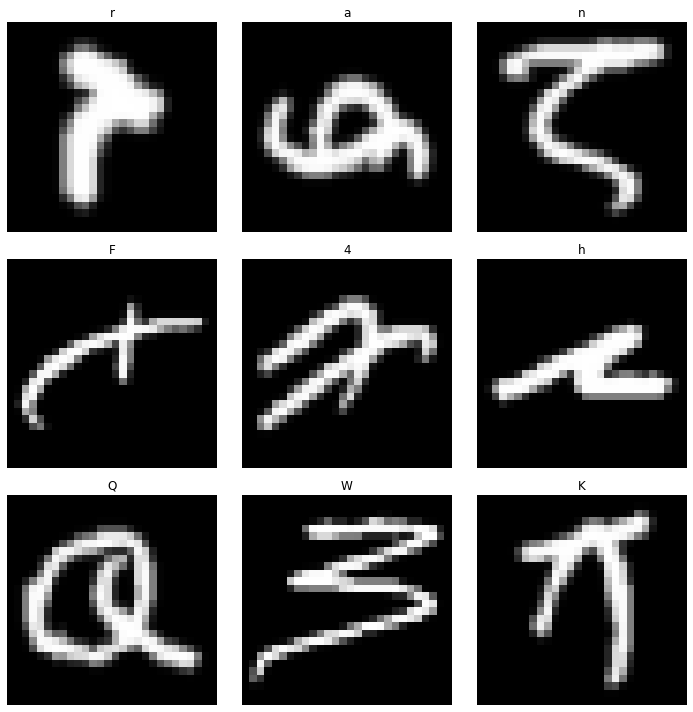

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img, label = trainset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off') 
plt.tight_layout()
plt.show()

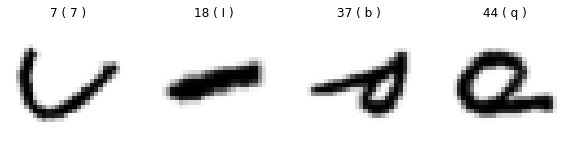

In [11]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        images = images / 2 + 0.5
        plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
        title = str(labels[i].item()) + ' ( ' + trainset.classes[labels[i].item()] + ' )'
        plt.title(title)
        plt.axis('off')

show_images(*next(iter(trainloader)))

### Generator Class

In [12]:
class Generator(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.fc = nn.Linear(config['latent_dimension'], 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x    

### Instantiating the Generator class

In [13]:
model_generator = Generator(config).to(device)
print(model_generator)

Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


### Discriminator Class

In [14]:
model_disc = models.vgg11(pretrained=True)
model_disc.classifier[6] = nn.Linear(4096, 1)


class Discriminator(torch.nn.Module):
    
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg_layers = vgg_model.features
        self.conv0 = torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = torch.nn.Dropout2d(0.25)
        self.conv1 = torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = torch.nn.Dropout2d(0.25)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = torch.nn.Dropout2d(0.25)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.1)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.3)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.4)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/ayushabrol/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [15]:
model_disc

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Instantiating the Discriminator class

In [16]:
model_discriminator = Discriminator(model_disc).to(device)

In [17]:
model_discriminator

Discriminator(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [18]:
config

{'batch_size': 128,
 'num_epochs': 30,
 'num_classes': 47,
 'learning_rate': 0.0001,
 'momentum': 0.9,
 'latent_dimension': 100,
 'hidden_dimension': 256,
 'betas_generator': (0.5, 0.999),
 'betas_discriminator': (0.5, 0.999),
 'num_workers': 2,
 'img_shape': torch.Size([1, 28, 28])}

### Setting up the loss function and the optimizers for the two networks

In [19]:
critertion = nn.BCEWithLogitsLoss()
optimizer_generator = optim.Adam(model_generator.parameters(), lr=config['learning_rate'], betas=config['betas_generator'])
optimizer_discriminator = optim.Adam(model_discriminator.parameters(), lr=config['learning_rate'], betas=config['betas_discriminator'])

### Random noise generation function for latent noise vectors

In [20]:
def noise_gen(batch_size, dim, choice='random'):
    return torch.rand(batch_size, dim).to(device)

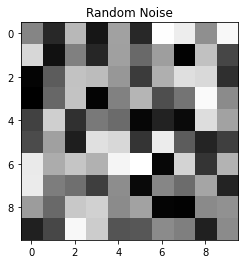

In [21]:
a1 = noise_gen(64, 100)
b1 = a1[0]
b1 = b1.reshape(10, 10)
b1 = b1.cpu().numpy()
plt.imshow(b1, cmap='gray')
plt.title('Random Noise')
plt.show()

### Functions for generator and discriminator loss

In [22]:
def generator_loss(fake_output, label):
    gen_loss = nn.BCELoss()(fake_output, label)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = nn.BCELoss()(output, label)
    return disc_loss

In [23]:
discriminator_loss_list = []
generator_loss_list = []

In [24]:
from tqdm import tqdm
from torch.autograd import Variable

### Function for saving the plots of loss of generator and discriminator during training

In [25]:
def save_plot_loss(d_loss, g_loss, epoch):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss - EPOCH " + str(epoch))
    plt.plot(g_loss, label="G")
    plt.plot(d_loss, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('./plots/losses/loss_plot_epoch_' + str(epoch) + '.png')
    plt.close()

### Training the DCGAN

In [26]:
print("Training Started...")
print("-"*50)
start_time = timeit.default_timer()
total_time = 0
D_LOSS_LIST_OVERALL = []
G_LOSS_LIST_OVERALL = []

for epoch in range(1, config["num_epochs"]+1): 
 
    D_loss_list, G_loss_list = [], []
    
    for index, (real_images, _) in enumerate(trainloader):
        optimizer_discriminator.zero_grad()
        real_images = real_images.to(device)
       
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
        # print(model_discriminator(real_images).shape, real_target.shape, real_images.shape, fake_target.shape)
        # print(model_discriminator(real_images), real_target)
        D_real_loss = discriminator_loss(model_discriminator(real_images), real_target)
        D_real_loss.backward()
     
        noise_vector = torch.randn(real_images.size(0), config["latent_dimension"], device=device)  
        
        generated_image = model_generator(noise_vector)
        output = model_discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,  fake_target)
        D_fake_loss.backward()

        D_total_loss = (D_real_loss + D_fake_loss) 
        D_loss_list.append(D_total_loss.item())
        D_LOSS_LIST_OVERALL.append(D_total_loss.item())
        optimizer_discriminator.step()
 
        optimizer_generator.zero_grad()
        G_total_loss = generator_loss(model_discriminator(generated_image), real_target)
        G_loss_list.append(G_total_loss.item())
        G_LOSS_LIST_OVERALL.append(G_total_loss.item())
 
        G_total_loss.backward()
        optimizer_generator.step()

        if index % 100 == 0:
            print(f'Epoch [{epoch}/{config["num_epochs"]}] Batch {index+1}/{len(trainloader)} \
            Loss D: {D_total_loss:.4f}, loss G: {G_total_loss:.4f}')

    
    print(f'Epoch [{epoch}/{config["num_epochs"]}] Batch {index+1}/{len(trainloader)} \
            Loss D: {D_total_loss:.4f}, loss G: {G_total_loss:.4f}')
    discriminator_loss_list.append(torch.mean(torch.FloatTensor(D_loss_list)))
    generator_loss_list.append(torch.mean(torch.FloatTensor(G_loss_list)))
    save_plot_loss(discriminator_loss_list, generator_loss_list, epoch)
    stop = timeit.default_timer()
    total_time += stop - start_time

    print(f"Time Elapsed for Epoch {epoch}: {stop - start_time} seconds")
    print(f"Total Time Elapsed: {total_time} seconds")
    print("-"*50)

    if epoch % 5 == 0:
        # Saving the Generator and Discriminator models
        torch.save(model_generator.state_dict(), f'./models/generator_{epoch}.pth')
        torch.save(model_discriminator.state_dict(), f'./models/discriminator_{epoch}.pth')

    if epoch == 1 or epoch == config["num_epochs"]//2 or epoch == config["num_epochs"]:
        # Generating 10 images for each epoch
        model_generator.eval()
        samples = model_generator(noise_gen(10, config["latent_dimension"])).detach().cpu()
        samples = samples.reshape(10, 28, 28)
        fig = plt.figure(figsize=(10, 10))
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(samples[i], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./plots/generated/generated_images_epoch_{epoch}.png')
        plt.close()
        model_generator.train()

print("Training Finished!")
print("Total Time Elapsed: {} seconds".format(total_time))

Training Started...
--------------------------------------------------
Epoch [1/30] Batch 1/882             Loss D: 1.3921, loss G: 0.6989
Epoch [1/30] Batch 101/882             Loss D: 0.0433, loss G: 9.2440
Epoch [1/30] Batch 201/882             Loss D: 0.0185, loss G: 9.2890
Epoch [1/30] Batch 301/882             Loss D: 0.0081, loss G: 11.1783
Epoch [1/30] Batch 401/882             Loss D: 0.0573, loss G: 8.5093
Epoch [1/30] Batch 501/882             Loss D: 0.0153, loss G: 9.0261
Epoch [1/30] Batch 601/882             Loss D: 0.1193, loss G: 7.0780
Epoch [1/30] Batch 701/882             Loss D: 0.2204, loss G: 6.5230
Epoch [1/30] Batch 801/882             Loss D: 0.1605, loss G: 5.1779
Epoch [1/30] Batch 882/882             Loss D: 0.1299, loss G: 4.5456
Time Elapsed for Epoch 1: 81.5141419 seconds
Total Time Elapsed: 81.5141419 seconds
--------------------------------------------------
Epoch [2/30] Batch 1/882             Loss D: 0.2775, loss G: 7.0554
Epoch [2/30] Batch 101/882 

In [26]:
# Loading the Generator and Discriminator models
model_generator.load_state_dict(torch.load('./models/generator_30.pth'))
model_discriminator.load_state_dict(torch.load('./models/discriminator_30.pth'))

<All keys matched successfully>

### Visualization of images generated from noise vectors

Generated Images after 1st Epoch


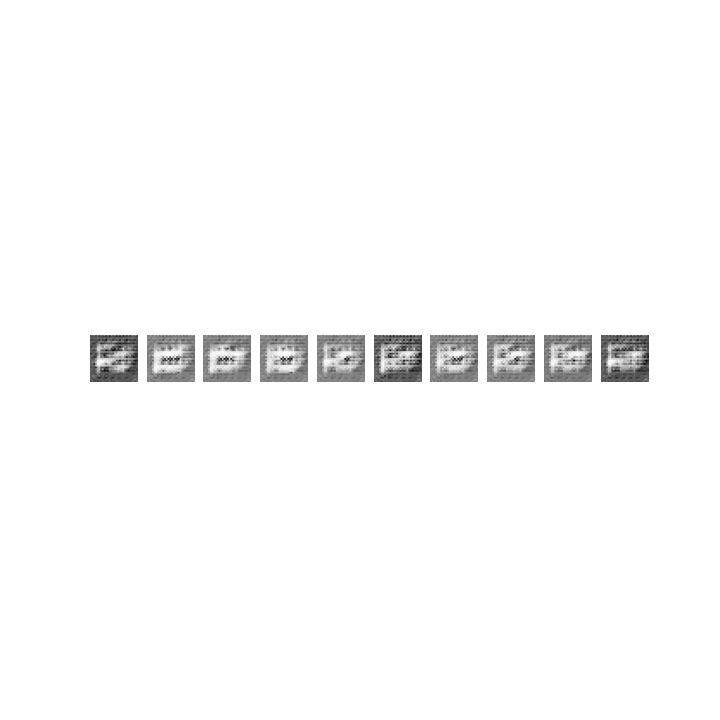

In [36]:
from IPython.display import Image
print("Generated Images after 1st Epoch")
Image('./plots/generated/generated_images_epoch_1.png')

Generated Images after 15th Epoch


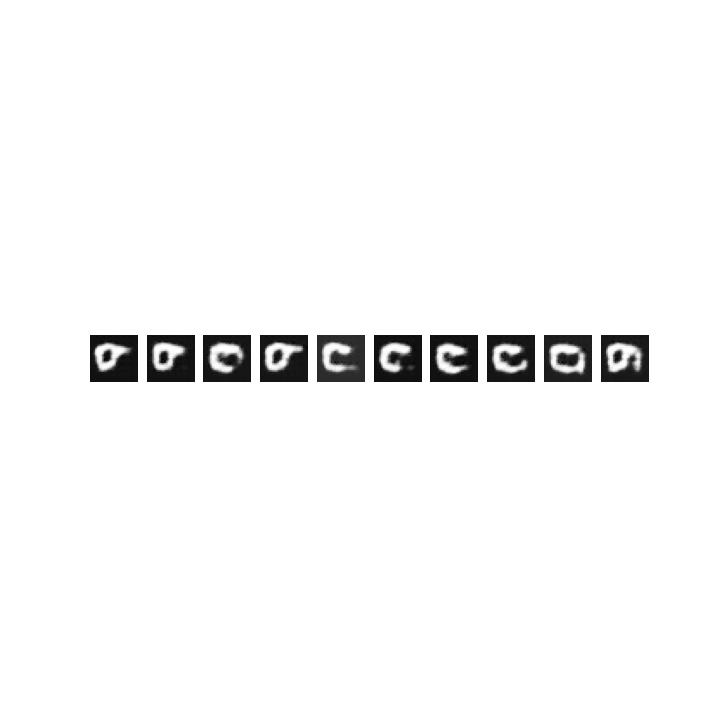

In [38]:
print("Generated Images after 15th Epoch")
Image('./plots/generated/generated_images_epoch_15.png')

Generated Images after 30th Epoch


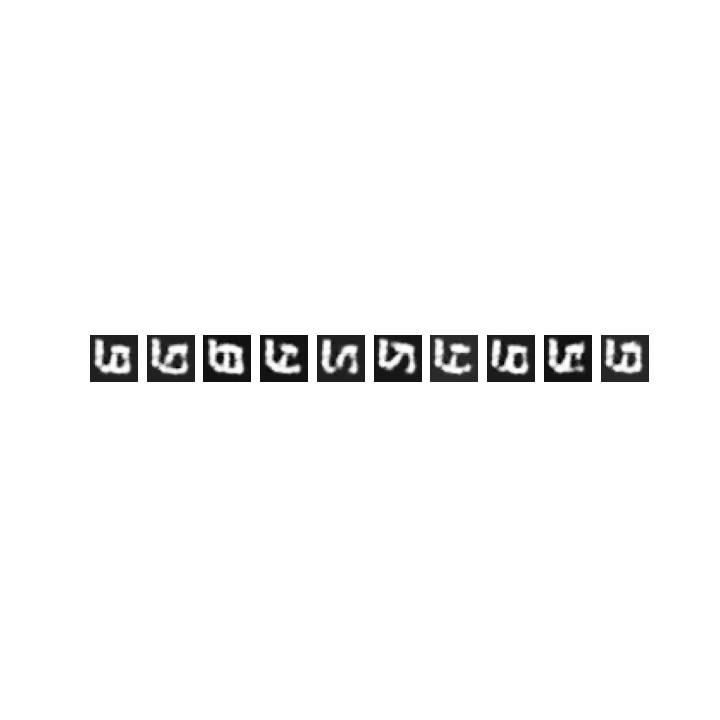

In [39]:
print("Generated Images after 30th Epoch")
Image('./plots/generated/generated_images_epoch_30.png')

### Plotting generator and discriminator losses for all the iterations.

In [28]:
import imageio
import os
images = []
for filename in os.listdir('./plots/losses'):
    images.append(imageio.imread('./plots/losses/' + filename))
imageio.mimsave('./plots/losses/losses.gif', images, fps=5)


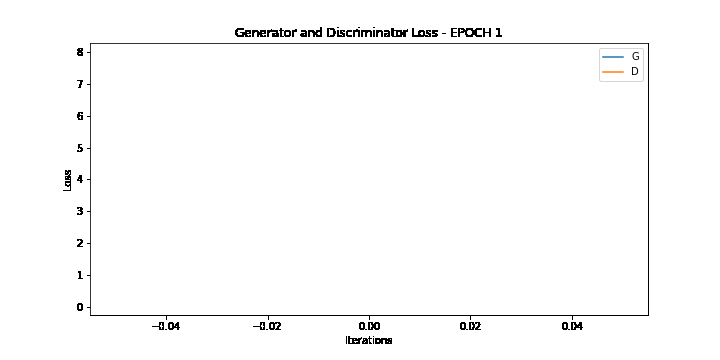

In [29]:
from IPython.display import Image
Image(open('./plots/losses/losses.gif','rb').read())

### Displaying the best-generated images by the model

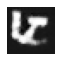

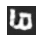

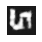

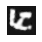

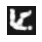

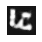

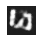

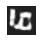

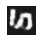

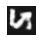

In [28]:
model_generator.eval()
samples = model_generator(noise_gen(10, config["latent_dimension"])).detach().cpu()
samples = samples.reshape(10, 28, 28)
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis('off')
    plt.show()
plt.close()

## Question: 02

### Download the pre-trained StyleGan(v1, v2 or v3). (I have downloaded the v3 GAN)
    
    1. Generate 10 realistic images using the StyleGAN.

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!git clone https://github.com/NVlabs/stylegan3.git

In [ ]:
!cd ../stylegan3/

!pip install ninja

In [ ]:
!python3 ./stylegan3/gen_images.py --outdir=out --trunc=1 --seeds=2 --network=stylegan3-r-ffhqu-256x256.pkl

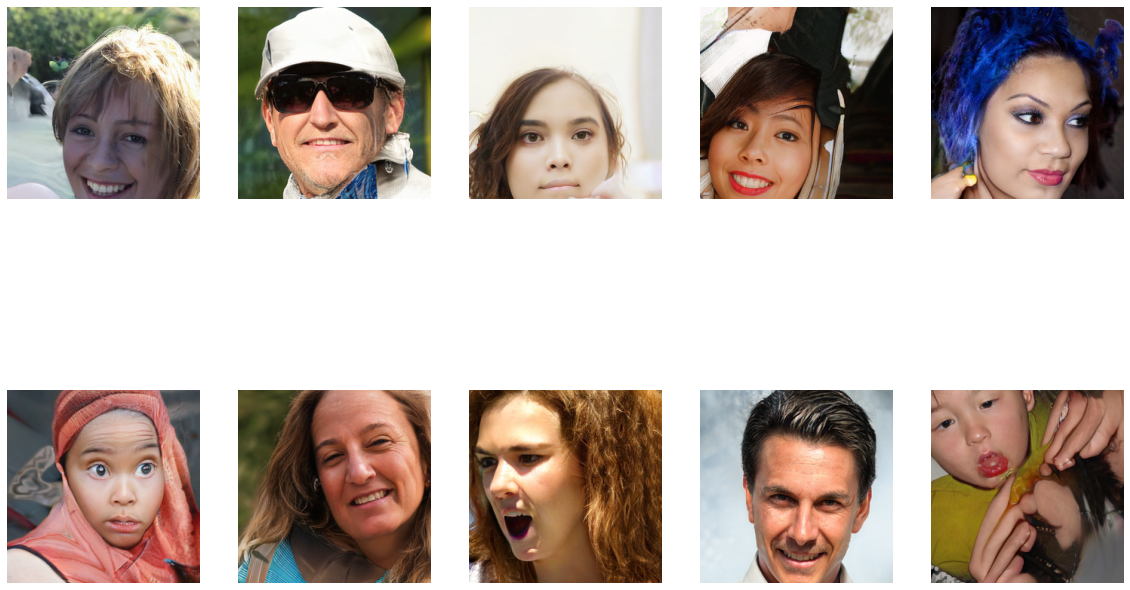

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

images = []
for filename in os.listdir('./out'):
    images.append(mpimg.imread('./out/' + filename))
plt.figure(figsize=(20, 20))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Part 2 of Question 2 is in a different ipynb file

---